## Dependencies

In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

## Summary:

## 1. Data Exploration/Preparation

Download datasets from here:
https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

In [6]:
spotify_df = pd.read_csv('data.csv')

In [7]:
spotify_df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


Observations:
1. This data is at a **song level**
2. Many numerical values that I'll be able to use to compare movies (liveness, tempo, valence, etc)
2. Release date will useful but I'll need to create a OHE variable for release date in 5 year increments
3. Similar to 2, I'll need to create OHE variables for the popularity. I'll also use 5 year increments here
4. There is nothing here related to the genre of the song which will be useful. This data alone won't help us find relavent content since this is a content based recommendation system. Fortunately there is a `data_w_genres.csv` file that should have some useful information

In [8]:
data_w_genre = pd.read_csv('data_w_genres.csv')
data_w_genre.head()

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.575083,0.442750,247260.000000,0.386336,0.022717,0.287708,-14.205417,0.180675,115.983500,0.334433,38.000000,5,1,12,['show tunes']
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,33.076923,5,1,26,[]
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.285714,0,1,7,[]
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.444444,0,1,27,[]
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.605444,0.437333,232428.111111,0.429333,0.037534,0.216111,-11.447222,0.086000,120.329667,0.458667,42.555556,11,1,9,[]


Observations:
1. This data is at an **artist level**
2. There are similar continuous variables as our initial dataset but I won't use this. I'll just use the values int he previous dataset. 
3. The genres are going to be really useful here and I'll need to use it moving forward. Now, the genre column appears to be in a list format but my past experience tells me that it's likely not. Let's investigate this further.

In [9]:
data_w_genre.dtypes

artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
genres               object
dtype: object

This checks whether or not `genres` is actually in a list format:

In [10]:
data_w_genre['genres'].values[0]

"['show tunes']"

In [11]:
data_w_genre['genres'].values[0][0]

'['

In [12]:
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [13]:
data_w_genre['genres_upd'].values[0][0]

'show_tunes'

In [15]:
spotify_df['artists'].values[0]

"['Carl Woitschach']"

In [16]:
spotify_df['artists_upd_v1'].values[0][0]

'Carl Woitschach'

In [17]:
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1
127,0.995,"[""Sam Manning's and His Cole Jazz Orchestra""]",0.664,173333,0.283,0,42WDMm9hX0xCFkkKpt6NOY,0.87400,8,0.109,-18.301,0,Bungo,0,1930-01-01,0.0807,99.506,0.688,1930,[]
180,0.984,"[""Scarlet D'Carpio""]",0.400,142443,0.190,0,4Gcc2YB0AAlzPLQhosdyAw,0.90000,0,0.182,-12.062,1,Chililin Uth'aja,0,1930,0.0492,81.290,0.402,1930,[]
1244,0.506,"[""Original Broadway Cast Of 'Flahooley""]",0.519,35227,0.475,0,1Qt9zpHUfVqMNr25EU9IFL,0.07100,7,0.103,-9.553,0,Prologue,0,1951-01-01,0.1070,105.639,0.615,1951,[]
1478,0.809,"[""Cal Tjader's Modern Mambo Quintet""]",0.795,238200,0.386,0,5VeW5QJDW906P5knRgJWzt,0.87400,1,0.106,-14.984,1,Dearly Beloved,2,1954-09-11,0.0570,119.800,0.807,1954,[]
1944,0.804,"[""Screamin' Jay Hawkins""]",0.574,142893,0.401,0,6MC85zBk1dQqnywRDdzy7h,0.00002,2,0.546,-11.185,1,I Love Paris,14,1958,0.0533,89.848,0.587,1958,[]


In [18]:
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'] )

In [19]:
#need to create my own song identifier because there are duplicates of the same song with different ids. I see different
spotify_df['artists_song'] = spotify_df.apply(lambda row: row['artists_upd'][0]+row['name'],axis = 1)

In [20]:
spotify_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [21]:
spotify_df[spotify_df['name']=='Adore You']

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
97046,0.1110,['Miley Cyrus'],0.583,278747,0.655,0,5AnCLGg35ziFOloEnXK4uu,0.000004,0,0.113,-5.407,1,Adore You,70,2013-10-04,0.0315,119.759,0.201,2013,[Miley Cyrus],[],[Miley Cyrus],Miley CyrusAdore You
87868,0.0237,['Harry Styles'],0.676,207133,0.771,0,3jjujdWJ72nww5eGnfs2E7,0.000007,8,0.102,-3.675,1,Adore You,88,2019-12-13,0.0483,99.048,0.569,2019,[Harry Styles],[],[Harry Styles],Harry StylesAdore You
87883,0.0237,['Harry Styles'],0.676,207133,0.771,0,1M4qEo4HE3PRaCOM7EXNJq,0.000007,8,0.102,-3.675,1,Adore You,86,2019-12-06,0.0483,99.048,0.569,2019,[Harry Styles],[],[Harry Styles],Harry StylesAdore You


In [22]:
spotify_df.drop_duplicates('artists_song',inplace = True)

In [23]:
spotify_df[spotify_df['name']=='Adore You']

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
97046,0.1110,['Miley Cyrus'],0.583,278747,0.655,0,5AnCLGg35ziFOloEnXK4uu,0.000004,0,0.113,-5.407,1,Adore You,70,2013-10-04,0.0315,119.759,0.201,2013,[Miley Cyrus],[],[Miley Cyrus],Miley CyrusAdore You
87868,0.0237,['Harry Styles'],0.676,207133,0.771,0,3jjujdWJ72nww5eGnfs2E7,0.000007,8,0.102,-3.675,1,Adore You,88,2019-12-13,0.0483,99.048,0.569,2019,[Harry Styles],[],[Harry Styles],Harry StylesAdore You


In [24]:
artists_exploded = spotify_df[['artists_upd','id']].explode('artists_upd')

In [25]:
artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [26]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['id'] =='6KuQTIu1KoTTkLXKrwlLPV']

,artists_upd,id,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres,genres_upd
51108,Robert Schumann,6KuQTIu1KoTTkLXKrwlLPV,Robert Schumann,0.98417,0.362023,212320.169960,0.105301,0.782029,0.160324,-22.831075,0.048055,98.447067,0.277442,3.723320,5.0,1.0,253.0,"['classical', 'early romantic era']","[classical, early_romantic_era]"
51109,Vladimir Horowitz,6KuQTIu1KoTTkLXKrwlLPV,Vladimir Horowitz,0.99007,0.343210,266541.125104,0.118844,0.879508,0.183812,-23.193418,0.043360,94.900679,0.225951,3.592378,1.0,1.0,1207.0,"['classical', 'classical performance', 'classi...","[classical, classical_performance, classical_p..."


In [27]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()

In [28]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [29]:
artists_genres_consolidated.head()

,id,genres_upd,consolidates_genre_lists
0,000G1xMMuwxNHmwVsBdtj1,"[[candy_pop, dance_rock, new_romantic, new_wav...","[new_romantic, candy_pop, power_pop, permanent..."
1,000ZxLGm7jDlWCHtcXSeBe,"[[boogie-woogie, piano_blues, ragtime, stride]]","[piano_blues, ragtime, stride, boogie-woogie]"
2,000jBcNljWTnyjB4YO7ojf,[[]],[]
3,000mGrJNc2GAgQdMESdgEc,"[[classical, late_romantic_era], [historic_orc...","[historic_orchestral_performance, classical, o..."
4,000u1dTg7y1XCDXi80hbBX,"[[country, country_road, country_rock]]","[country_road, country_rock, country]"


In [30]:
spotify_df = spotify_df.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')

## 2. Feature Engineering

### - Normalized the float variables
### - OHE Year and Popularity Variables
### - Created TF-IDF features off of artist genres

In [31]:
spotify_df.tail()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists
155464,0.0287,"[""Livin' Joy"", 'A. Manetta']",0.704,215227,0.722,0,5cIU5GZBbyMfgfXGcoQVYc,0.00341,2,0.297,-10.815,0,Don't Stop Movin' - Radio Mix,56,1997-01-01,0.0446,129.992,0.859,1997,"[ Joy"", ]",[Livin' Joy],"[ Joy"", ]","Joy"", Don't Stop Movin' - Radio Mix",NaN
155465,0.0218,"[""Lil' Flip"", 'Lea']",0.845,225187,0.346,0,3FaUH7ZMjW1hv9Jx6MIAIf,0.00000,0,0.135,-9.381,1,Sunshine (feat. Lea),47,2004-03-30,0.1060,93.989,0.819,2004,"[ Flip"", ]",[Lil' Flip],"[ Flip"", ]","Flip"", Sunshine (feat. Lea)",NaN
155466,0.0516,"[""Ol' Dirty Bastard"", 'Kelis', 'Rich Travali']",0.934,239547,0.459,1,6YYd5MLpu45J0uLrMdivF7,0.00000,1,0.222,-7.654,1,Got Your Money (feat. Kelis),66,1999,0.1890,103.040,0.697,1999,"[ Dirty Bastard"", , , ]",[Ol' Dirty Bastard],"[ Dirty Bastard"", , , ]","Dirty Bastard"", Got Your Money (feat. Kelis)",NaN
155467,0.0249,"[""World Class Wreckin' Cru"", ""Michel 'Le""]",0.715,351040,0.490,0,3hoiinUc5VA9xUEJID7R8V,0.00017,9,0.139,-9.504,0,Turn Off The Lights - Rap,35,1994-04-06,0.0479,129.309,0.429,1994,"[ Cru"", ""Michel ]","[World Class Wreckin' Cru, Michel 'Le]","[ Cru"", ""Michel ]","Cru"", ""Michel Turn Off The Lights - Rap",NaN
155468,0.0113,"[""Rappin' 4-Tay"", 'MC Breed', 'Too $hort']",0.897,337973,0.414,1,78859Af0fmA9VTlgnOHTAP,0.00011,4,0.101,-8.450,0,Never Talk Down,35,1996,0.2460,96.039,0.273,1996,"[ 4-Tay"", , , ]",[Rappin' 4-Tay],"[ 4-Tay"", , , ]","4-Tay"", Never Talk Down",NaN


In [32]:
spotify_df['year'] = spotify_df['release_date'].apply(lambda x: x.split('-')[0])

In [33]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [34]:
ohe_cols = 'popularity'

In [35]:
spotify_df['popularity'].describe()

count    155469.000000
mean         31.306987
std          21.422973
min           0.000000
25%          12.000000
50%          33.000000
75%          48.000000
max          97.000000
Name: popularity, dtype: float64

In [36]:
# create 5 point buckets for popularity 
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [37]:
# tfidf can't handle nulls so fill any null values with an empty list
spotify_df['consolidates_genre_lists'] = spotify_df['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [65]:
spotify_df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,popularity_red
0,0.381,['黑豹'],0.353,316160,0.6860,0,3KIuCzckjdeeVuswPo20mC,0.000000,11,0.0568,-9.103,1,DON'T BREAK MY HEART,34,1992-12-22,0.0395,200.341,0.3520,1992,[黑豹],[],[黑豹],黑豹DON'T BREAK MY HEART,"[chinese_indie, chinese_indie_rock]",6
1,0.978,['黃蜀娟'],0.153,156813,0.0581,0,7dkMnOK1h9I3D2NyDDjBfh,0.000939,10,0.1550,-23.697,1,輕煙濃霧,23,1968-02-28,0.0472,174.060,0.0904,1968,[黃蜀娟],[],[黃蜀娟],黃蜀娟輕煙濃霧,[],4
2,0.828,['黃蜀娟'],0.508,100133,0.2470,0,7ilXPF7IilGtVX4MMubQfQ,0.000000,3,0.2970,-14.241,1,踏雪尋梅,23,1968-02-28,0.1730,170.629,0.6800,1968,[黃蜀娟],[],[黃蜀娟],黃蜀娟踏雪尋梅,[],4
3,0.909,['黃蜀娟'],0.140,284040,0.1310,0,3enJcaHwRwN3ABPp3Bae35,0.000042,10,0.6190,-20.946,1,藍色的月光,23,1968-01-28,0.0455,82.543,0.1160,1968,[黃蜀娟],[],[黃蜀娟],黃蜀娟藍色的月光,[],4
4,0.944,['黃蜀娟'],0.604,173627,0.2100,0,6aewX7cGeXnZTK36bZRI6T,0.000007,0,0.2110,-17.312,1,薔薇之戀,23,1968-01-28,0.0395,105.531,0.5380,1968,[黃蜀娟],[],[黃蜀娟],黃蜀娟薔薇之戀,[],4


In [38]:
#simple function to create OHE features
#this gets passed later on
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df


In [40]:
#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [41]:
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)#.mean(axis = 0)

In [42]:
complete_feature_set.head()

genre|432hz  genre|_hip_hop  genre|a_cappella  genre|abstract  \
0          0.0             0.0               0.0             0.0   
1          0.0             0.0               0.0             0.0   
2          0.0             0.0               0.0             0.0   
3          0.0             0.0               0.0             0.0   
4          0.0             0.0               0.0             0.0   

   genre|abstract_beats  genre|abstract_hip_hop  genre|accordeon  \
0                   0.0                     0.0              0.0   
1                   0.0                     0.0              0.0   
2                   0.0                     0.0              0.0   
3                   0.0                     0.0              0.0   
4                   0.0                     0.0              0.0   

   genre|accordion  genre|acid_house  genre|acid_jazz  genre|acid_rock  \
0              0.0               0.0              0.0              0.0   
1              0.0               0.0              0.0              0.0   
2              0.0               0.0              0.0              0.0   
3              0.0               0.0              0.0              0.0   
4              0.0               0.0              0.0              0.0   

   genre|acid_trance  genre|acousmatic  genre|acoustic  genre|acoustic_blues  \
0                0.0               0.0             0.0                   0.0   
1                0.0               0.0             0.0                   0.0   
2                0.0               0.0             0.0                   0.0   
3                0.0               0.0             0.0                   0.0   
4                0.0               0.0             0.0                   0.0   

   genre|acoustic_pop  genre|acoustic_punk  genre|adoracion  \
0                 0.0                  0.0              0.0   
1                 0.0                  0.0              0.0   
2                 0.0                  0.0              0.0   
3                 0.0                  0.0              0.0   
4                 0.0                  0.0              0.0   

   genre|adult_standards  genre|adventista  genre|afghan_pop  \
0                    0.0               0.0               0.0   
1                    0.0               0.0               0.0   
2                    0.0               0.0               0.0   
3                    0.0               0.0               0.0   
4                    0.0               0.0               0.0   

   genre|african_gospel  genre|african_percussion  genre|african_reggae  \
0                   0.0                       0.0                   0.0   
1                   0.0                       0.0                   0.0   
2                   0.0                       0.0                   0.0   
3                   0.0                       0.0                   0.0   
4                   0.0                       0.0                   0.0   

   genre|african_rock  genre|afro  genre|afro_dancehall  genre|afro_house  \
0                 0.0         0.0                   0.0               0.0   
1                 0.0         0.0                   0.0               0.0   
2                 0.0         0.0                   0.0               0.0   
3                 0.0         0.0                   0.0               0.0   
4                 0.0         0.0                   0.0               0.0   

   genre|afro_psych  genre|afrobeat  genre|afrobeat_brasileiro  \
0               0.0             0.0                        0.0   
1               0.0             0.0                        0.0   
2               0.0             0.0                        0.0   
3               0.0             0.0                        0.0   
4               0.0             0.0                        0.0   

   genre|afrofuturism  genre|afrofuturismo_brasileiro  genre|afropop  \
0                 0.0                             0.0            0.0   
1                 0.0                   

## 3. Connect to Spotify API


In [43]:
client_id = 'id'
client_secret= 'secret'

In [44]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [45]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [46]:
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8881/')

In [47]:
sp = spotipy.Spotify(auth=token)

In [48]:
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [66]:
id_name

{'My Peloton Music by madsthaks': '2ERUubOm9fCqSehYVio8bY',
 'chill': '0VjrxXF0S8wdkr8MLUaoFO',
 'EDM': '49q1SNpthDWA9D5ECbas6J',
 'My Shazam Tracks': '4nSIFeOEHqb0APbPVBvOy2',
 'kanye': '6lMQskYSwbK1RJUXeZYmv4',
 'marathon': '15RqI2qiCq5jD2KU0mD1I5',
 'Starred': '4mVCQMqnVVmZYIDnKjAImj',
 'Underground Hits': '37i9dQZF1DX30HHrCAl4ZG',
 'DJ Top 50 🎧 club music, remix, bootleg, mashup': '6jVUGg95c9A37iGOj2GMBb',
 'Running Electro': '3JDbVHBjEpM4PEuNwBlMRG',
 'Quentin Tarantino’s Django Unchained Original Motion Picture Soundtrack': '47ANSoONFl9iZlgErkYwmj',
 'Epic': '2Np7ZFr3jwITwuCvtxe5m6',
 'Alternative R&B': '3HG3Uca5gTcmZIEmyJl8NB',
 'Epic Classical': '37i9dQZF1DX9G9wwzwWL2k',
 'Chill': '3Atmxx4GS7g9U1IhAin1VL',
 'Electro House +': '2izYujPRo6mMFCGVuJMlFW',
 '3LAU': '41qGXzlHqXZwABw6D9l7LA',
 'Club/House/Electro/Trance': '62mXsdRriKgYjliP82CSti'}

In [49]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [50]:
id_name

{'My Peloton Music by madsthaks': '2ERUubOm9fCqSehYVio8bY',
 'chill': '0VjrxXF0S8wdkr8MLUaoFO',
 'EDM': '49q1SNpthDWA9D5ECbas6J',
 'My Shazam Tracks': '4nSIFeOEHqb0APbPVBvOy2',
 'kanye': '6lMQskYSwbK1RJUXeZYmv4',
 'marathon': '15RqI2qiCq5jD2KU0mD1I5',
 'Starred': '4mVCQMqnVVmZYIDnKjAImj',
 'Underground Hits': '37i9dQZF1DX30HHrCAl4ZG',
 'DJ Top 50 🎧 club music, remix, bootleg, mashup': '6jVUGg95c9A37iGOj2GMBb',
 'Running Electro': '3JDbVHBjEpM4PEuNwBlMRG',
 'Quentin Tarantino’s Django Unchained Original Motion Picture Soundtrack': '47ANSoONFl9iZlgErkYwmj',
 'Epic': '2Np7ZFr3jwITwuCvtxe5m6',
 'Alternative R&B': '3HG3Uca5gTcmZIEmyJl8NB',
 'Epic Classical': '37i9dQZF1DX9G9wwzwWL2k',
 'Chill': '3Atmxx4GS7g9U1IhAin1VL',
 'Electro House +': '2izYujPRo6mMFCGVuJMlFW',
 '3LAU': '41qGXzlHqXZwABw6D9l7LA',
 'Club/House/Electro/Trance': '62mXsdRriKgYjliP82CSti'}

In [51]:
playlist_EDM = create_necessary_outputs('EDM', id_name,spotify_df)
#playlist_chill = create_necessary_outputs('chill',id_name, spotify_df)
#playlist_classical = create_necessary_outputs('Epic Classical',id_name, spotify_df)

In [52]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [53]:
playlist_EDM

,artist,name,id,url,date_added
39,Martin Garrix,Drown (feat. Clinton Kane),4RVtBlHFKj51Ipvpfv5ER4,https://i.scdn.co/image/ab67616d00001e02b154bc...,2020-08-01 01:27:34+00:00
37,Riton,Turn Me On (feat. Vula),0qaWEvPkts34WF68r8Dzx9,https://i.scdn.co/image/ab67616d00001e02216a27...,2020-07-09 01:34:03+00:00
34,RL Grime,UCLA,3OaunNUlXXs5e2PXtNAzzG,https://i.scdn.co/image/ab67616d00001e02eded2e...,2020-06-20 00:34:44+00:00
33,SAINt JHN,Roses - Imanbek Remix,7fPuWrlpwDcHm5aHCH5D9t,https://i.scdn.co/image/ab67616d00001e022b6e2f...,2020-04-19 06:26:21+00:00
30,Loud Luxury,Body,21RzyxY3EFaxVy6K4RqaU9,https://i.scdn.co/image/ab67616d00001e02af5e18...,2020-03-26 22:28:23+00:00
28,ZHU,Working For It,2HJQcyUpmUuvzS5vBAICIc,https://i.scdn.co/image/ab67616d00001e02bfaac9...,2019-12-19 15:53:47+00:00
26,Lastlings,Deja Vu,649HM5lOHHqsoG5nldMo6L,https://i.scdn.co/image/ab67616d00001e02129817...,2019-11-19 16:04:48+00:00
25,Avicii,Waiting For Love,2P4OICZRVAQcYAV2JReRfj,https://i.scdn.co/image/ab67616d00001e025393c5...,2019-11-17 03:38:47+00:00
24,Regard,Ride It,2tnVG71enUj33Ic2nFN6kZ,https://i.scdn.co/image/ab67616d00001e025c2781...,2019-11-13 04:13:21+00:00
20,Dimitri Vegas & Like Mike,Mammoth,76fqWMe0buqQoaNTIbLWmr,https://i.scdn.co/image/ab67616d00001e0216bf35...,2019-10-26 19:11:43+00:00


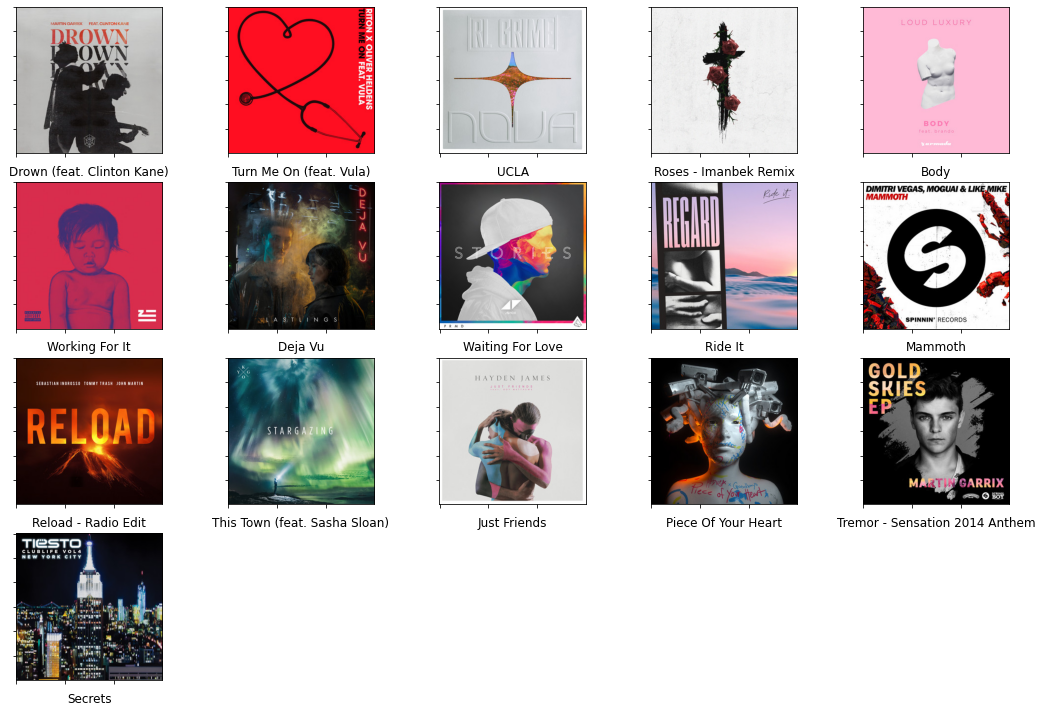

In [54]:
visualize_songs(playlist_EDM)

## 4. Create Playlist Vector

In [56]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [58]:
complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM = generate_playlist_feature(complete_feature_set, playlist_EDM, 1.09)
#complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill = generate_playlist_feature(complete_feature_set, playlist_chill, 1.09)

In [67]:
complete_feature_set_playlist_vector_EDM.shape

(2758,)

## 5. Generate Recommendations

In [60]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [61]:
edm_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM)

In [68]:
edm_top40

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,popularity_red,sim,url
10730,0.06430,"['Valerie Broussard', 'Galantis']",0.683,184564,0.785,0,23FHa9lYnG6Dr8OzombPkS,0.000013,7,0.1770,-4.879,1,Roots,69,2019-08-16,0.0370,122.997,0.5810,2019,"[Valerie Broussard, Galantis]",[],"[Valerie Broussard, Galantis]",Valerie BroussardRoots,"[tropical_house, edm, dance_pop, big_room, pop...",13,0.777350,https://i.scdn.co/image/ab67616d00001e02bfe4e6...
135509,0.01600,"['Calvin Harris', ""Rag'n'Bone Man""]",0.807,229184,0.887,0,5itOtNx0WxtJmi1TQ3RuRd,0.000503,1,0.0811,-4.311,0,Giant (with Rag'n'Bone Man),80,2019-01-11,0.0361,122.015,0.6060,2019,"[Calvin Harris, n]",[Rag'n'Bone Man],"[Calvin Harris, n]",Calvin HarrisGiant (with Rag'n'Bone Man),"[progressive_house, tropical_house, edm, uk_da...",16,0.744758,https://i.scdn.co/image/ab67616d00001e02a9a9d8...
70513,0.08100,"['Loud Luxury', 'Bryce Vine']",0.875,187797,0.858,0,7fcEMgPlojD0LzPHwMsoic,0.000001,4,0.3810,-3.886,1,I'm Not Alright,65,2019-12-20,0.0496,121.978,0.7000,2019,"[Loud Luxury, Bryce Vine]",[],"[Loud Luxury, Bryce Vine]",Loud LuxuryI'm Not Alright,"[tropical_house, edm, pop_rap, dance_pop, pop,...",13,0.730603,https://i.scdn.co/image/ab67616d00001e02d48c7e...
106357,0.02820,['Galantis'],0.674,191293,0.915,0,6M6Tk58pQvABy6ru66dY3d,0.003370,6,0.2730,-3.999,0,No Money,69,2017-09-15,0.0411,126.038,0.7800,2017,[Galantis],[],[Galantis],GalantisNo Money,"[tropical_house, edm, dance_pop, big_room, pop...",13,0.728139,https://i.scdn.co/image/ab67616d00001e0271340c...
106353,0.11700,"['Galantis', 'Throttle']",0.762,190400,0.797,0,5kgqTe1BM720OjU78TGYDw,0.000000,5,0.2020,-2.710,1,Tell Me You Love Me,60,2017-09-15,0.1350,122.066,0.5250,2017,"[Galantis, Throttle]",[],"[Galantis, Throttle]",GalantisTell Me You Love Me,"[tropical_house, edm, dance_pop, big_room, pop...",12,0.726095,https://i.scdn.co/image/ab67616d00001e0271340c...
100074,0.22900,"['Gryffin', 'Katie Pearlman']",0.590,231291,0.764,0,17ejRbr6B8l9zdqgCZsn4m,0.000000,2,0.1920,-4.735,1,Nobody Compares To You (feat. Katie Pearlman),66,2019-10-24,0.0467,104.911,0.3310,2019,"[Gryffin, Katie Pearlman]",[],"[Gryffin, Katie Pearlman]",GryffinNobody Compares To You (feat. Katie Pea...,"[tropical_house, edm, dance_pop, pop, electro_...",13,0.720858,https://i.scdn.co/image/ab67616d00001e020e5311...
106355,0.00104,['Galantis'],0.708,203133,0.945,0,3aIhJDHxr1kgTSnutJxPTH,0.080300,5,0.2270,-3.247,0,Peanut Butter Jelly,66,2015-06-05,0.2340,127.960,0.5450,2015,[Galantis],[],[Galantis],GalantisPeanut Butter Jelly,"[tropical_house, edm, dance_pop, big_room, pop...",13,0.719479,https://i.scdn.co/image/ab67616d00001e022b5179...
146679,0.08660,"['Axwell /\\ Ingrosso', 'Axwell', 'Sebastian I...",0.467,254653,0.757,0,4b2tcjrG1qUkSdsqEFP2dB,0.000000,2,0.0742,-3.010,1,Sun Is Shining,72,2017-07-28,0.0517,131.993,0.3830,2017,"[Axwell /\\ Ingrosso, Axwell, Sebastian Ingrosso]",[],"[Axwell /\\ Ingrosso, Axwell, Sebastian Ingrosso]",Axwell /\\ IngrossoSun Is Shining,"[progressive_house, tropical_house, edm, dance...",14,0.717821,https://i.scdn.co/image/ab67616d00001e02fba6de...
106361,0.00463,"['Galantis', 'OneRepublic']",0.658,205793,0.804,0,1pfgsjmxVZhoZpeDx6POKv,0.000000,0,0.1780,-5.735,1,Bones (feat. OneRepublic),73,2019-01-31,0.0377,120.047,0.5080,2019,"[Galantis, OneRepublic]",[],"[Galantis, OneRepublic]",GalantisBones (feat. OneRepublic),"[piano_rock, tropical_house, pop_rock, edm, da...",14,0.711158,https://i.scdn.co/image/ab67616d00001e02344d2f...
106354,0.00711,['Galantis'],0.506,227074,0.805,0,46lFttIf5hnUZMGvjK0Wxo,0.001930,1,0.0856,-4.119,1,Runaway (U & I),75,2015-06-05,0.0469,126.008,0.3830,2015,[Galantis],[],[Galantis],GalantisRunaway (U & I),"[tropical_house, edm, dance_pop, big_room, pop...",15,0.711128,https://i.scdn.co/image/ab67616d00001e022b5

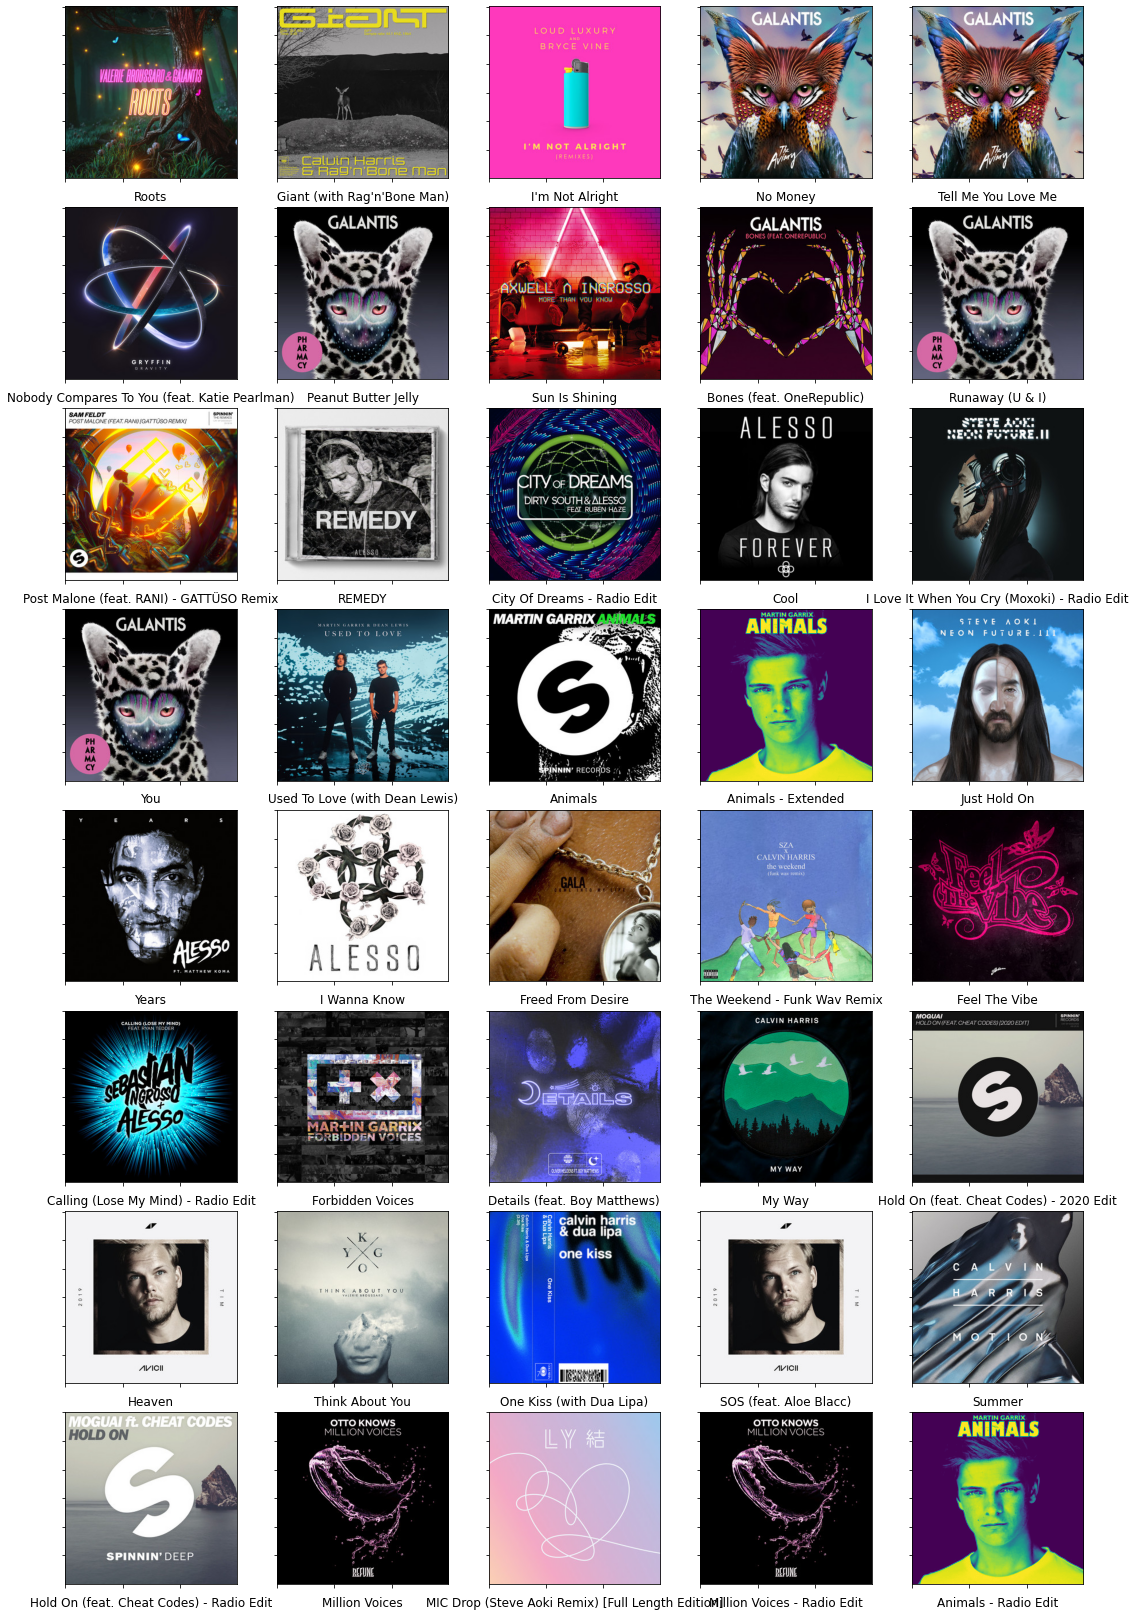

In [63]:
visualize_songs(edm_top40)

In [ ]:
chill_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill)